## Wine quality modelling

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df= pd.read_pickle('df_preprocessed.pkl')

model_features= ['density_t', 'is_red', 'fixed_acidity',
                 'volatile_acidity', 'citric_acid', 'residual_sugar',
                 'chlorides','free_sulfur_dioxide', 'total_sulfur_dioxide',
                 'pH', 'sulphates','alcohol']

output = 'quality'

### Sample with few instances at edges 3, 4, 8, 9

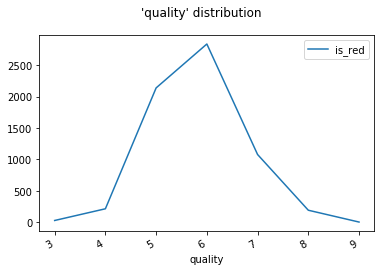

In [3]:
df[['quality','is_red']].groupby(output).count().plot(subplots =True, title = "'quality' distribution")
plt.show()

In [4]:
# inbalanced sample, to few observations at 3,9
df.groupby(output).is_red.count()

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: is_red, dtype: int64

In [5]:
# just checking correlation of model features before baseline regression
df[model_features].corr()

,density_t,is_red,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol
density_t,1.000000,-0.070816,-0.269153,-0.029593,-0.121701,-0.182887,-0.065977,-0.003742,-0.011442,0.050796,-0.093319,0.096052
is_red,-0.070816,1.000000,0.486740,0.653036,-0.187397,-0.348821,0.512678,-0.471644,-0.700357,0.329129,0.487218,-0.033384
fixed_acidity,-0.269153,0.486740,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,-0.252700,0.299568,-0.095555
volatile_acidity,-0.029593,0.653036,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.261454,0.225984,-0.037715
citric_acid,-0.121701,-0.187397,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,-0.329808,0.056197,-0.009987
residual_sugar,-0.182887,-0.348821,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,-0.267320,-0.185927,-0.359245
chlorides,-0.065977,0.512678,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.044708,0.395593,-0.257136
free_sulfur_dioxide,-0.003742,-0.471644,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,-0.145854,-0.188457,-0.179435
total_sulfur_dioxide,-0.011442,-0.700357,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,-0.238413,-0.275727,-0.265550
pH,0.050796,0.329129,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,1.000000,0.192123,0.121139


### Some useful modules

In [6]:
def weight(n, counts):
    """Returns the balancing weight for a certain category"""
    categories = counts.count()
    return 1/counts[n]/categories

weight_vfunc = np.vectorize(weight, excluded=['counts'])

def oversampling(df):
    """Transforms unbalanced sample into balanced by
    oversampling less frequent categories"""
    
    size = 7
    # Imbalanced sample, let's fix it by sampling    
    weights_vector = weight_vfunc(df[output],counts= df[output].value_counts())
    df_=df.sample(n=len(df)*size, frac=None, replace=True, weights=weights_vector, random_state=42)
    return df_

# Feature engeneering: interactions and high order terms
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=False,degree=2)

In [7]:
from sklearn import linear_model
from sklearn import tree
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor,MLPClassifier 
from sklearn.ensemble import GradientBoostingRegressor

regressors ={
    "Linear": linear_model.LinearRegression(),
    "Lasso":linear_model.Lasso(alpha=0.3,max_iter=100000),
    #"KNN": neighbors.KNeighborsRegressor(n_neighbors=30),
    #"DecisionTree" : tree.DecisionTreeRegressor(max_depth=5),
    #"MLP": MLPClassifier(hidden_layer_sizes=(200, 200,), activation='logistic',max_iter=100000)
}

In [8]:
# Optimization Story

# gradient boosting learning rate cross validation
# Gradient Boosting 0.04 : 0.65 , 0.14, 1.21

# gradient boosting max_depth cross validation
# Gradient Boosting 6.00 : 0.55 , 0.28, 1.18
# Gradient Boosting 8.00 : 0.48 , 0.37, 1.18
# Gradient Boosting 10.00 : 0.43 , 0.43, 1.19
# Gradient Boosting 12.00 : 0.41 , 0.47, 1.18*
# Gradient Boosting 14.00 : 0.40 , 0.48, 1.20


# gradient boosting alpha cross validation


for rate in np.arange(12,14,2):
    print(rate)
    regressors["Gradient Boosting %.2f" % (rate)] = GradientBoostingRegressor(loss='lad',
                              learning_rate=0.04,
                              n_estimators=100,
                              subsample=1.0,
                              criterion='friedman_mse',
                              min_samples_split=2,
                              min_samples_leaf=1,
                              min_weight_fraction_leaf=0.0,
                              max_depth=12, 
                              min_impurity_decrease=0.0,
                              min_impurity_split=None,
                              init=None,
                              random_state=42,
                              max_features=None,
                              alpha=0.3)

12


In [9]:
from sklearn.metrics import mean_squared_error, r2_score

def performance_validation(y_pred, y_test, print_graph = True):
    # The mean squared error
    mean_square_error = mean_squared_error(y_test, y_pred)
    variance_score = r2_score(y_test, y_pred)

    df_measures = pd.DataFrame(
        np.transpose(np.array([y_pred,y_test])), columns = ["y_pred","y_test"])
    df_measures=df_measures.assign(y_pred_round =lambda x: np.round(x.y_pred))
    df_measures=df_measures.assign(y_pred_sqrt =lambda x: (x.y_pred -x.y_test)**2)
    
    rmse = np.sqrt(df_measures.groupby('y_test').y_pred_sqrt.mean())
    print("Mean squared error, Variance Score, RMSE: %.2f %.2f %.2f" 
          % (mean_square_error,variance_score,rmse.mean()))
        
    # quality at extremes
    if print_graph == True:
        fig, ax = plt.subplots(figsize=(15, 5))
        plt.subplot(1,3,1)
        plt.title("RMSE averaged: %.2f"%(rmse.mean()))
        plt.bar(rmse.index,rmse.values,width=0.5,color='b',align='center')
        plt.subplot(1,3,2)
        plt.title("distribution of output - validation")
        v=df_measures.groupby('y_test').y_pred.count()
        plt.plot(v.index,v.values)
        plt.subplot(1,3,3)
        plt.title('average pedicted quality')
        v =(df_measures.groupby('y_test').y_pred.mean())
        plt.bar(v.index,v.values,width=0.5,color='b',align='center')
        plt.show()
        df_measures[['y_pred','y_test']].boxplot(by = 'y_test', figsize = (15,5))
        plt.show()
    return df_measures,mean_square_error,variance_score,rmse.mean()

In [10]:
from sklearn.model_selection import StratifiedKFold, KFold
from copy import deepcopy
def cross_validation_fitting_performance(reg, df, y,reg_name="", use_poly=False, oversample=True):
    skf = StratifiedKFold(n_splits=10,random_state=42, shuffle =True)
    skf.get_n_splits(df, y)

    performace_results = np.array([])
    y_pred_y_test_list = list()
    reg_list = list()
    for train_index, test_index in skf.split(df, y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        df_train, df_test = df.loc[train_index], df.loc[test_index]
        
        if oversample:
            df_train = oversampling(df_train).copy()
            #print(format(df_train[output].value_counts()))
        else:
            pass
        
        X_train, y_train = df_train[model_features], df_train[output]
        X_test, y_test = df_test[model_features], df_test[output]

        if use_poly:
            X_train = poly.fit_transform(X_train)
            X_test = poly.transform(X_test)

        reg.fit(X_train,y_train)
        y_pred = reg.predict(X_test)
        
        y_pred_y_test_list.append(deepcopy((y_pred,y_test)))
        reg_list.append(deepcopy(reg))
        df_measures,mean_square_error,variance_score, rmse = performance_validation(y_pred, y_test, print_graph = False)
        if len(performace_results):
            performace_results = np.concatenate((performace_results, np.array([[mean_square_error,variance_score,rmse]])))
        else: 
            performace_results = np.array([[mean_square_error,variance_score,rmse]])
            
    res = tuple(performace_results.mean(0))
    t=(reg_name, )+res
    print(t)
    if reg_name == "":
        print ("%s : %.2f , %.2f, %.2f" % t)
    else:
        print ("%s : %.2f , %.2f, %.2f" % t)
    return y_pred_y_test_list, reg_list

### Simple regression for baseline performance

In [10]:
y_pred_y_test_dic={}
reg_dic = {}
filtered_regressors = {k:v for (k,v) in regressors.items() if "Linear" == k}
for name in filtered_regressors:
    df, y = df,df[output]
    #X,y = df_poly,df[output].values
    y_pred_y_test_dic[name], reg_dic[name] = cross_validation_fitting_performance(
        regressors[name], df,y,name, use_poly = False, oversample = False)
    print()

C:\Users\Mariana\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Mean squared error, Variance Score, RMSE: 0.53 0.30 1.24
Mean squared error, Variance Score, RMSE: 0.52 0.33 1.46
Mean squared error, Variance Score, RMSE: 0.54 0.29 1.27
Mean squared error, Variance Score, RMSE: 0.56 0.27 1.64
Mean squared error, Variance Score, RMSE: 0.55 0.27 1.29
Mean squared error, Variance Score, RMSE: 0.55 0.29 1.41
Mean squared error, Variance Score, RMSE: 0.51 0.32 1.22
Mean squared error, Variance Score, RMSE: 0.57 0.26 1.46
Mean squared error, Variance Score, RMSE: 0.53 0.31 1.47
Mean squared error, Variance Score, RMSE: 0.56 0.25 1.37
('Linear', 0.542605065543119, 0.288238398581005, 1.385110423608439)
Linear : 0.54 , 0.29, 1.39



Mean squared error, Variance Score, RMSE: 0.56 0.27 1.64


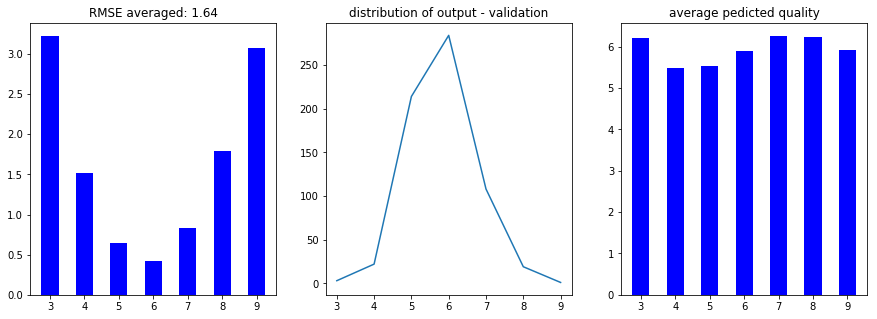

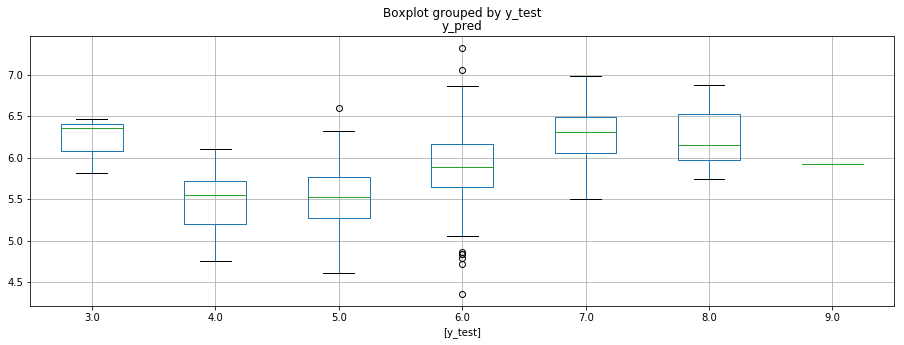

In [13]:
# print performance assessment
df_measures,mean_square_error,variance_score, rmse=performance_validation(*y_pred_y_test_dic['Linear'][3])

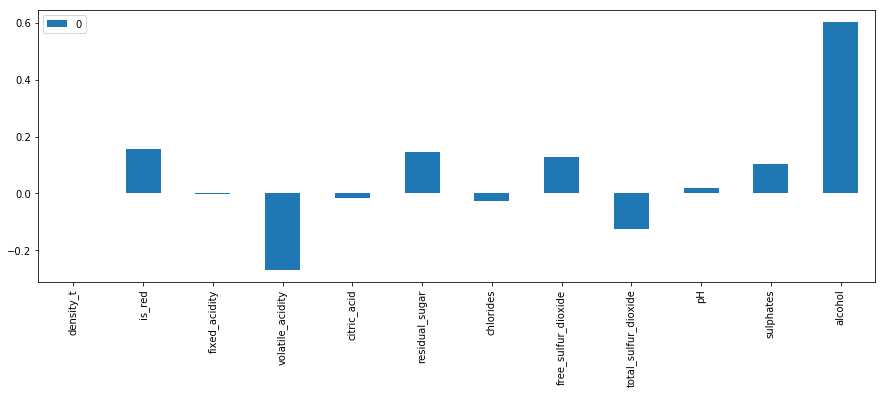

In [14]:
reg = reg_dic["Linear"][1]
df_coeff =pd.DataFrame(reg.coef_,index=model_features)
df_coeff.plot(kind='bar', figsize = (15,5))
plt.show()

### Using polynomial features, balanced sampling and Stratifyed K-fold Cross Validation, for several techniques. 

In [11]:
y_pred_y_test_dic={}
reg={}
filtered_regressors = {k:v for (k,v) in regressors.items() if "Linear" != k}

for name in filtered_regressors:
    df, y = df,df[output]
    #X,y = df_poly,df[output].values
    y_pred_y_test_dic[name], reg[name]= cross_validation_fitting_performance(regressors[name], df,y,name, use_poly = True)
    print()

C:\Users\Mariana\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Mean squared error, Variance Score, RMSE: 0.63 0.17 1.24
Mean squared error, Variance Score, RMSE: 0.60 0.23 1.46
Mean squared error, Variance Score, RMSE: 0.68 0.11 1.31
Mean squared error, Variance Score, RMSE: 0.70 0.09 1.69
Mean squared error, Variance Score, RMSE: 0.67 0.11 1.33
Mean squared error, Variance Score, RMSE: 0.65 0.15 1.40
Mean squared error, Variance Score, RMSE: 0.67 0.11 1.46
Mean squared error, Variance Score, RMSE: 0.69 0.10 1.41
Mean squared error, Variance Score, RMSE: 0.60 0.21 1.41
Mean squared error, Variance Score, RMSE: 0.80 -0.07 1.93
('Lasso', 0.6690891994429535, 0.12192560002264152, 1.4634521575359747)
Lasso : 0.67 , 0.12, 1.46

Mean squared error, Variance Score, RMSE: 0.40 0.47 1.09
Mean squared error, Variance Score, RMSE: 0.39 0.50 1.24
Mean squared error, Variance Score, RMSE: 0.46 0.40 1.16
Mean squared error, Variance Score, RMSE: 0.40 0.49 1.43
Mean squared error, Variance Score, RMSE: 0.39 0.49 1.03
Mean squared error, Variance Score, RMSE: 0.40

In [12]:
y_pred_y_test_dic.keys()

dict_keys(['Lasso', 'Gradient Boosting 12.00'])

Mean squared error, Variance Score, RMSE: 0.40 0.48 1.10


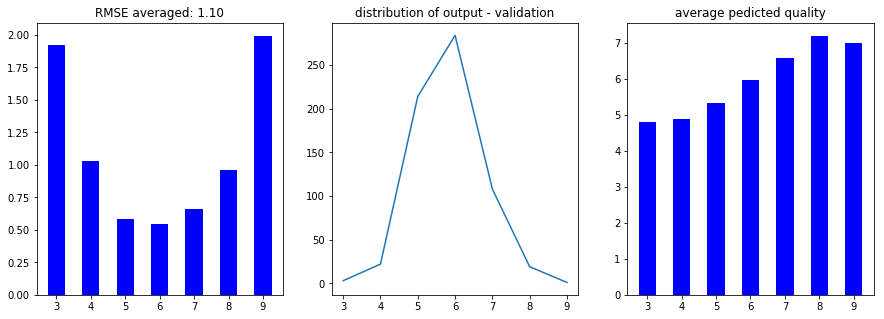

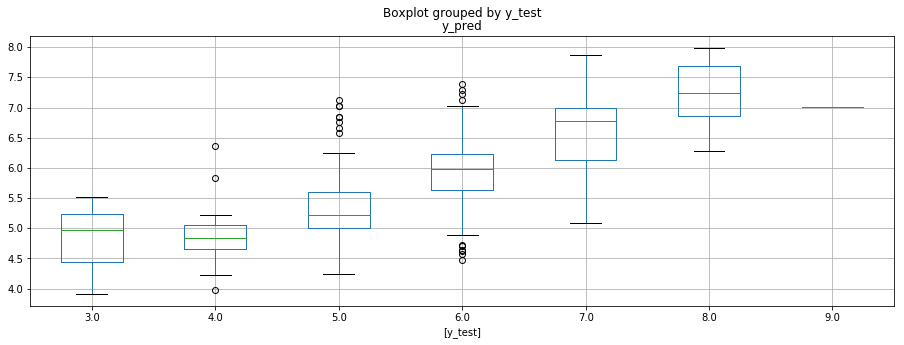

In [20]:
df_measures,mean_square_error,variance_score, rmse=performance_validation(*y_pred_y_test_dic['Gradient Boosting 12.00'][5])

In [22]:
#Final model "Gradient Boosting" presents better performance
#Gradient Boosting : 0.68 , 0.11, 1.22

y_pred_y_test_dic={}
reg = regressors['Gradient Boosting 12.00']

df_train = oversampling(df).copy()
X_train, y_train = df_train[model_features], df_train[output]
X_train = poly.fit_transform(X_train)
reg.fit(X_train,y_train)

from sklearn.externals import joblib
joblib.dump(reg, 'wine_quality_model.pkl')

['wine_quality_model.pkl']